In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [2]:
import optuna
import copy
from tqdm import tqdm
import shutil
import os
from datetime import datetime
# from torchsummary import summary

/Users/kkozik/Library/anaconda3/envs/torch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.manual_seed(42)

# Loading the CIFAR-10 Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform)

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:07<00:00, 21718384.33it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Sample Images with Labels

- Classes

In [5]:
classes = train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
def imshow(img, labels, batch_size):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.figure(figsize=(batch_size*2, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    
    for i in range(len(labels)):
        plt.text(i * (npimg.shape[2] / len(labels)) + (npimg.shape[2] / (2 * len(labels))), 
                   -2,
                   classes[labels[i]], 
                   ha='center', 
                   va='bottom', 
                   fontsize=12,
                   color='white', 
                   bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    
    plt.show()

In [7]:
batch_size = 8
dataiter = iter(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))

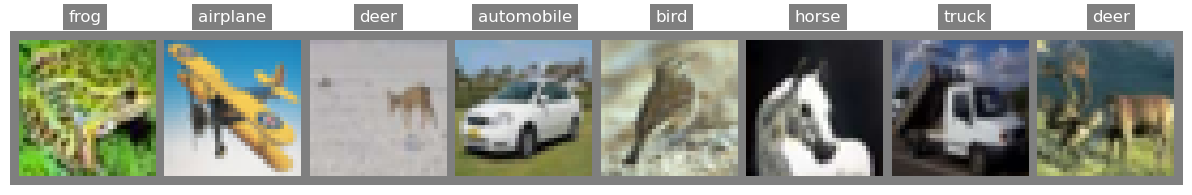

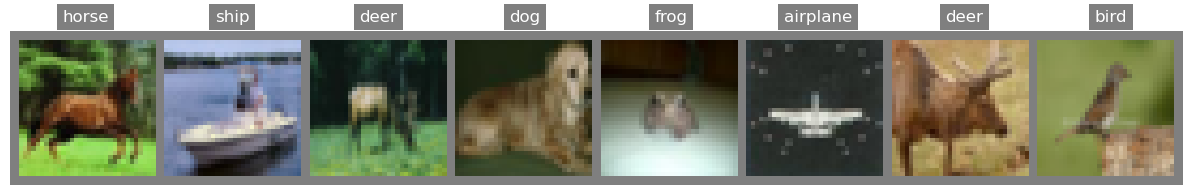

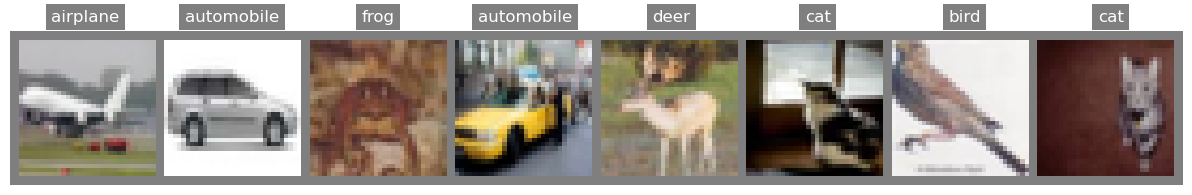

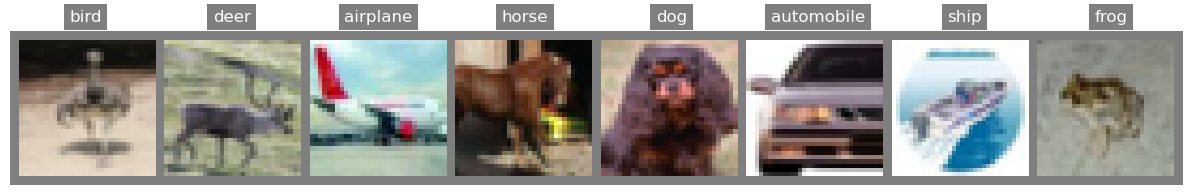

In [8]:
for _ in range(4):
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images), labels, batch_size)

# LeNet-5

## Model Architecture

In [9]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Adjusted input features for MLP in CIFAR-10
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # Softmax will be applied in the loss function
        return x

In [10]:
model = LeNet5()
device = torch.device("mps")
model.to(device)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

- Initialize model weights

In [11]:
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')  # He initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [12]:
model.apply(init_weights)
clear_output()

## Dataset Split

In [13]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Training

In [14]:
learning_rate = 0.001
early_stopping_patience = 5
max_epochs = 100
steps_without_improvement = 0

In [15]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [16]:
train_losses = []
val_losses = []

In [17]:
best_val_loss = np.inf
best_model = None

In [18]:
for epoch in range(max_epochs):
    print(f"Epoch {epoch+1}/{max_epochs}")
    
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Training Batches"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in tqdm(val_loader, desc="Validation Batches"):
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item() * val_inputs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        steps_without_improvement = 0
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
    else:
        steps_without_improvement += 1
        print(f"Epoch {epoch+1} wasn't better than the previous")

    if steps_without_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break


Epoch 1/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 154.63it/s]


Training Loss: 1.6295, Validation Loss: 1.4377
Epoch 2/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 154.01it/s]


Training Loss: 1.3435, Validation Loss: 1.3267
Epoch 3/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 160.04it/s]


Training Loss: 1.2307, Validation Loss: 1.2384
Epoch 4/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 160.11it/s]


Training Loss: 1.1532, Validation Loss: 1.1904
Epoch 5/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 159.93it/s]


Training Loss: 1.0890, Validation Loss: 1.2194
Epoch 5 wasn't better than the previous
Epoch 6/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 160.03it/s]


Training Loss: 1.0367, Validation Loss: 1.1653
Epoch 7/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 157.62it/s]


Training Loss: 0.9928, Validation Loss: 1.1527
Epoch 8/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 158.62it/s]


Training Loss: 0.9497, Validation Loss: 1.1141
Epoch 9/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 149.66it/s]


Training Loss: 0.9109, Validation Loss: 1.1361
Epoch 9 wasn't better than the previous
Epoch 10/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 152.18it/s]


Training Loss: 0.8719, Validation Loss: 1.1194
Epoch 10 wasn't better than the previous
Epoch 11/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 157.37it/s]


Training Loss: 0.8359, Validation Loss: 1.1354
Epoch 11 wasn't better than the previous
Epoch 12/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 159.52it/s]


Training Loss: 0.7994, Validation Loss: 1.1526
Epoch 12 wasn't better than the previous
Epoch 13/100


Validation Batches: 100%|██████████| 79/79 [00:00<00:00, 160.11it/s]

Training Loss: 0.7680, Validation Loss: 1.2013
Epoch 13 wasn't better than the previous
Early stopping at epoch 13


In [19]:
def plot_training_validation_loss(train_losses, val_losses):
    num_epochs = len(train_losses)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

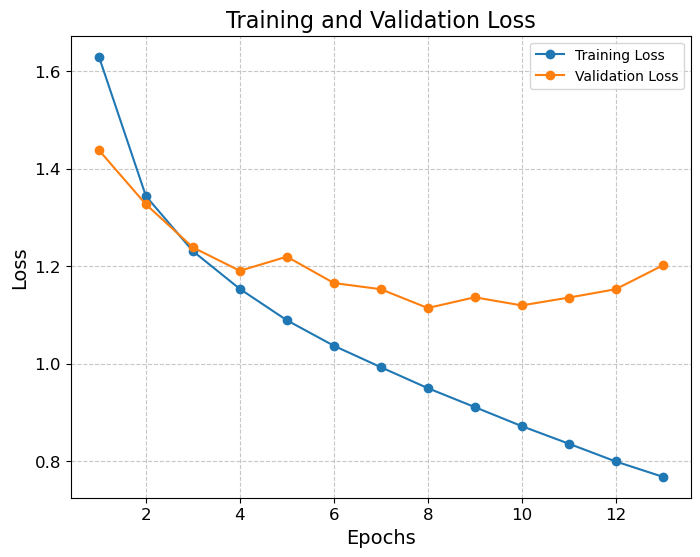

In [20]:
plot_training_validation_loss(train_losses, val_losses)

## Model Evaluation on the Test Set

In [26]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        outputs = model(test_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 61.15%


## Hyperparameters Optimization and Model Upgrade

### Dataset Preparation and Augmentation

In [58]:
def remove_dataset_on_disk():
    if os.path.exists('./data'):
        shutil.rmtree('./data')
        print("Removing 'data' folder")
    else:
        print("'data' folder does not exists")

In [21]:
remove_dataset_on_disk()

Removing 'data' folder


In [22]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform_train)

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=transform_test)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


100%|██████████| 170498071/170498071 [00:07<00:00, 21801507.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Upgraded Model

In [23]:
class LeNet5(nn.Module):
    def __init__(self, conv1_out_channels=6, conv2_out_channels=16,
                 fc1_out_features=120, fc2_out_features=84, dropout_rate=0.0):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_out_channels, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, kernel_size=5)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(conv2_out_channels * 5 * 5, fc1_out_features)
        self.fc2 = nn.Linear(fc1_out_features, fc2_out_features)
        self.fc3 = nn.Linear(fc2_out_features, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [25]:
def objective(trial):
    # Save logs
    log_file = 'optimization_log_lenet.txt'
    
    # Hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    conv1_out_channels = trial.suggest_categorical('conv1_out_channels', [6, 24])
    conv2_out_channels = trial.suggest_categorical('conv2_out_channels', [16, 32, 64])
    fc1_out_features = trial.suggest_categorical('fc1_out_features', [120, 256])
    fc2_out_features = trial.suggest_categorical('fc2_out_features', [84, 128])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Dataloaders with tuned batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = LeNet5(
        conv1_out_channels=conv1_out_channels,
        conv2_out_channels=conv2_out_channels,
        fc1_out_features=fc1_out_features,
        fc2_out_features=fc2_out_features,
        dropout_rate=dropout_rate
    )

    device = torch.device("mps")
    model.to(device)
    model.apply(init_weights)

    # Adam with L2 regularization - tuned weight_decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    with open(log_file, 'a') as f:
        f.write(f"\n\n--- New Trial ---\n")
        f.write(f"Trial {trial.number} - {datetime.now()}\n")
        f.write(f"Hyperparameters: lr={lr}, conv1_out_channels={conv1_out_channels}, "
                f"conv2_out_channels={conv2_out_channels}, fc1_out_features={fc1_out_features}, "
                f"fc2_out_features={fc2_out_features}, dropout_rate={dropout_rate}, "
                f"weight_decay={weight_decay}, batch_size={batch_size}\n")

    num_epochs = 20
    for epoch in range(num_epochs):
        epoch_start_time = datetime.now()
        
        # Training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item() * val_inputs.size(0)
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total

        with open(log_file, 'a') as f:
            f.write(f"Epoch {epoch+1}/{num_epochs} - {epoch_start_time}\n"
                    f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                    f"Val Accuracy: {val_accuracy:.4f}\n")

        # Report intermediate results to Optuna
        trial.report(val_accuracy, epoch)

        # Handle pruning - moment when Optuna analyse results, and can skip this model configuration
        # when model is not performing better than previous models and configurations
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Evaluation on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            outputs = model(test_inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()
    test_accuracy = correct / total

    with open(log_file, 'a') as f:
        f.write(f"Final Test Accuracy: {test_accuracy:.4f} - {datetime.now()}\n")

    return test_accuracy

In [26]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-10-28 23:27:40,433] A new study created in memory with name: no-name-5ae1f3bf-087e-4787-b307-4044a4d6eb5e
/var/folders/bl/szgb52vx4p19h00643wv96mh0000gn/T/ipykernel_14947/1225328412.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/var/folders/bl/szgb52vx4p19h00643wv96mh0000gn/T/ipykernel_14947/1225328412.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
/var/folders/bl/szgb52vx4p19h00643wv96mh0000gn/T/ipykernel_14947/1225328412.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/opt

In [27]:
print("Best trial:")
trial = study.best_trial
print(f"Test Accuracy: {trial.value:.4f}")

Best trial:
Test Accuracy: 0.7160


In [28]:
print("Best hyperparameters:")
for key, value in trial.params.items():
    print(f"  - {key}: {value}")

Best hyperparameters:
  - lr: 0.000859071648578362
  - conv1_out_channels: 24
  - conv2_out_channels: 64
  - fc1_out_features: 120
  - fc2_out_features: 84
  - dropout_rate: 0.04020651325076101
  - weight_decay: 1.6838042308899545e-05
  - batch_size: 32


### Best modified LeNet model and results

In [29]:
best_hyperparameters = {
    'lr': 0.000859071648578362,
    'conv1_out_channels': 24,
    'conv2_out_channels': 64,
    'fc1_out_features': 120,
    'fc2_out_features': 84,
    'dropout_rate': 0.04020651325076101,
    'weight_decay': 1.6838042308899545e-05,
    'batch_size': 32
}

In [30]:
train_loader = DataLoader(train_dataset, batch_size=best_hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=best_hyperparameters['batch_size'], shuffle=False)

In [31]:
model = LeNet5(
    conv1_out_channels=best_hyperparameters['conv1_out_channels'],
    conv2_out_channels=best_hyperparameters['conv2_out_channels'],
    fc1_out_features=best_hyperparameters['fc1_out_features'],
    fc2_out_features=best_hyperparameters['fc2_out_features'],
    dropout_rate=best_hyperparameters['dropout_rate']
)

In [32]:
device = torch.device("mps")
model.to(device)

LeNet5(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.04020651325076101, inplace=False)
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [33]:
optimizer = optim.Adam(model.parameters(), lr=best_hyperparameters['lr'], weight_decay=best_hyperparameters['weight_decay'])
criterion = nn.CrossEntropyLoss()

In [34]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

Epoch 1/20: 100%|██████████| 1407/1407 [00:16<00:00, 83.61it/s]


Epoch 1/20, Train Loss: 1.6728


Epoch 2/20: 100%|██████████| 1407/1407 [00:16<00:00, 86.88it/s]


Epoch 2/20, Train Loss: 1.3994


Epoch 3/20: 100%|██████████| 1407/1407 [00:16<00:00, 86.34it/s]


Epoch 3/20, Train Loss: 1.2635


Epoch 4/20: 100%|██████████| 1407/1407 [00:16<00:00, 83.80it/s]


Epoch 4/20, Train Loss: 1.1717


Epoch 5/20: 100%|██████████| 1407/1407 [00:16<00:00, 86.50it/s]


Epoch 5/20, Train Loss: 1.1101


Epoch 6/20: 100%|██████████| 1407/1407 [00:16<00:00, 86.82it/s]


Epoch 6/20, Train Loss: 1.0666


Epoch 7/20: 100%|██████████| 1407/1407 [00:16<00:00, 86.64it/s]


Epoch 7/20, Train Loss: 1.0236


Epoch 8/20: 100%|██████████| 1407/1407 [00:16<00:00, 87.03it/s]


Epoch 8/20, Train Loss: 0.9940


Epoch 9/20: 100%|██████████| 1407/1407 [00:17<00:00, 80.36it/s]


Epoch 9/20, Train Loss: 0.9552


Epoch 10/20: 100%|██████████| 1407/1407 [00:17<00:00, 79.98it/s]


Epoch 10/20, Train Loss: 0.9325


Epoch 11/20: 100%|██████████| 1407/1407 [00:16<00:00, 86.90it/s]


Epoch 11/20, Train Loss: 0.9130


Epoch 12/20: 100%|██████████| 1407/1407 [00:16<00:00, 84.79it/s]


Epoch 12/20, Train Loss: 0.8852


Epoch 13/20: 100%|██████████| 1407/1407 [00:16<00:00, 83.53it/s]


Epoch 13/20, Train Loss: 0.8727


Epoch 14/20: 100%|██████████| 1407/1407 [00:16<00:00, 83.20it/s]


Epoch 14/20, Train Loss: 0.8600


Epoch 15/20: 100%|██████████| 1407/1407 [00:16<00:00, 84.96it/s]


Epoch 15/20, Train Loss: 0.8417


Epoch 16/20: 100%|██████████| 1407/1407 [00:16<00:00, 84.30it/s]


Epoch 16/20, Train Loss: 0.8299


Epoch 17/20: 100%|██████████| 1407/1407 [00:16<00:00, 83.04it/s]


Epoch 17/20, Train Loss: 0.8241


Epoch 18/20: 100%|██████████| 1407/1407 [00:16<00:00, 86.24it/s]


Epoch 18/20, Train Loss: 0.8005


Epoch 19/20: 100%|██████████| 1407/1407 [00:16<00:00, 83.12it/s]


Epoch 19/20, Train Loss: 0.7903


Epoch 20/20: 100%|██████████| 1407/1407 [00:16<00:00, 86.13it/s]

Epoch 20/20, Train Loss: 0.7804


In [53]:
def show_predictions(img, true_labels, predicted_labels, batch_size):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(batch_size * 2, 2))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    
    for i in range(len(true_labels)):
        label_text = f"True: {classes[true_labels[i]]}\nPred: {classes[predicted_labels[i]]}"
        plt.text(i * (npimg.shape[2] / len(true_labels)) + (npimg.shape[2] / (2 * len(true_labels))),
                 -2,
                 label_text,
                 ha='center',
                 va='bottom',
                 fontsize=12,
                 color='white',
                 bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
    
    plt.show()

In [56]:
def display_predictions(model, test_loader, classes, num_images=8, num_sample_rows=3):
    dataiter = iter(test_loader)
    for _ in range(num_sample_rows):
        images, labels = next(dataiter)
        images, labels = images[:num_images], labels[:num_images]
        images, labels = images.to(device), labels.to(device)

        model.eval()
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

        images = images.cpu()
        labels = labels.cpu()
        predicted = predicted.cpu()

        show_predictions(torchvision.utils.make_grid(images), labels, predicted, num_images)
        for i in range(len(labels)):
            print(f"True label: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}")

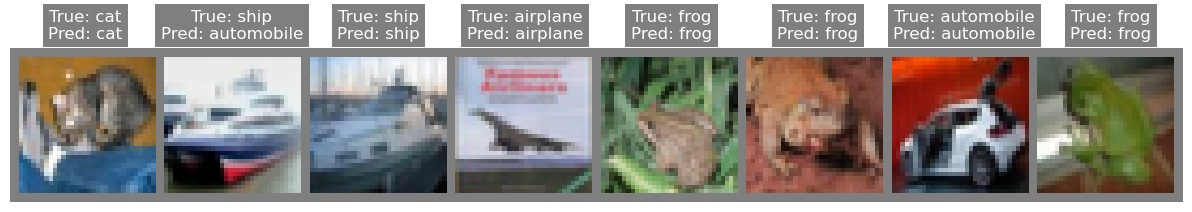

True label: cat, Predicted: cat
True label: ship, Predicted: automobile
True label: ship, Predicted: ship
True label: airplane, Predicted: airplane
True label: frog, Predicted: frog
True label: frog, Predicted: frog
True label: automobile, Predicted: automobile
True label: frog, Predicted: frog


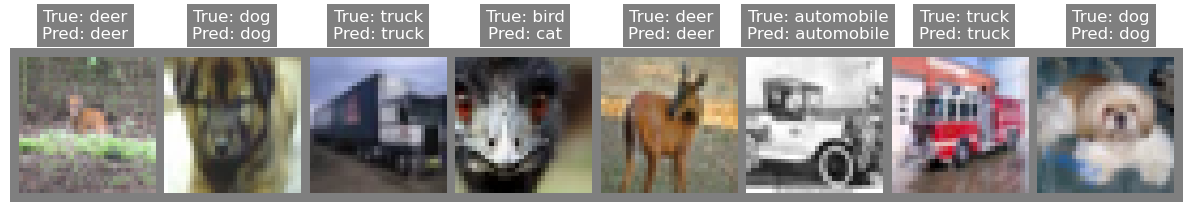

True label: deer, Predicted: deer
True label: dog, Predicted: dog
True label: truck, Predicted: truck
True label: bird, Predicted: cat
True label: deer, Predicted: deer
True label: automobile, Predicted: automobile
True label: truck, Predicted: truck
True label: dog, Predicted: dog


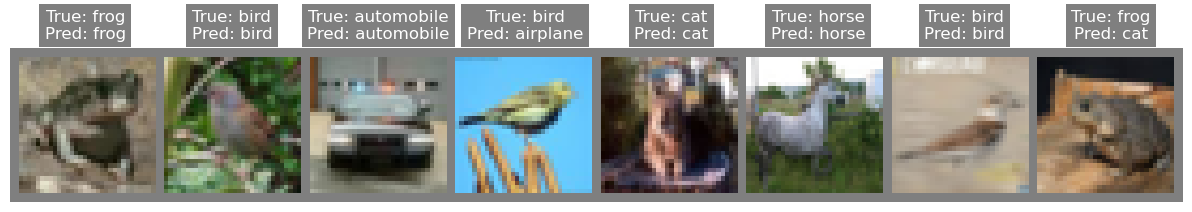

True label: frog, Predicted: frog
True label: bird, Predicted: bird
True label: automobile, Predicted: automobile
True label: bird, Predicted: airplane
True label: cat, Predicted: cat
True label: horse, Predicted: horse
True label: bird, Predicted: bird
True label: frog, Predicted: cat


In [57]:
display_predictions(model, test_loader, classes)

In [59]:
remove_dataset_on_disk()

Removing 'data' folder
